In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import faraday as fd

#%matplotlib notebook

## Simulation Parameters and Constants

In [65]:
FREQ = 30  # minimum frequency in MHz
NCHANS = 64  # frequency channels
NSIDE = 128
THETA_MAX = 5  # extent of point src in degrees
RM = 250  # rotation measure

frequencies = np.linspace(0, 25/1e3, NCHANS) + FREQ  # 64 channels of 390 Hz width
c = 299792458  # m / s

## Spectral Response

0.050025012506253574 2000


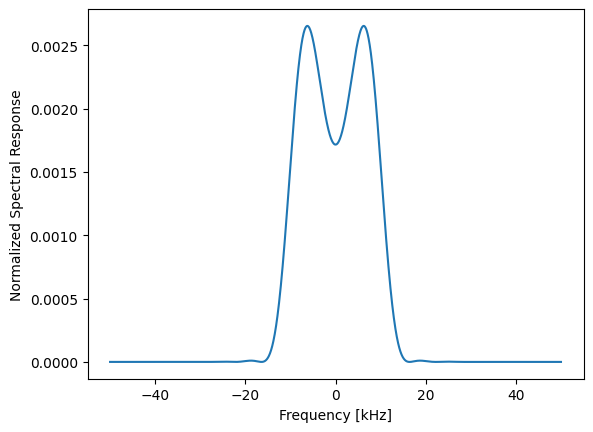

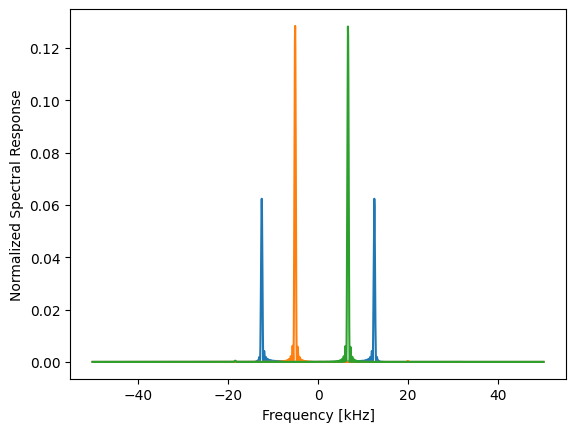

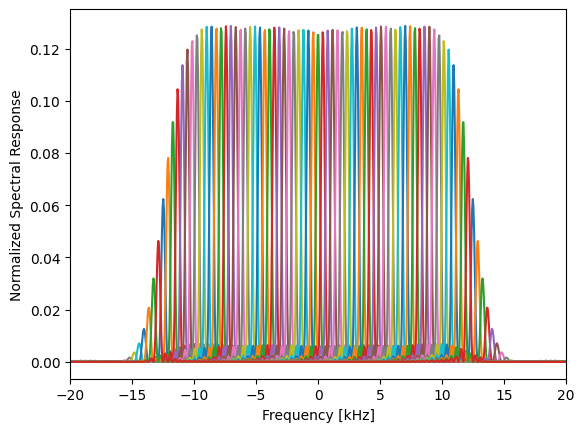

In [66]:
spec = np.loadtxt("../data/zoom_response_4tap.txt")
offset = spec[:, 0]  # / 1e3?? spacing in MHz
print(offset[1]-offset[0], len(offset))
# normalize response
spec = spec[:, 1:] / spec[:, 1:].sum(axis=0, keepdims=True)

plt.figure()
plt.plot(offset, spec[:, 0])
plt.xlabel("Frequency [kHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(offset, spec[:, 1])
plt.plot(offset, spec[:, 20])
plt.plot(offset, spec[:, 50])
plt.xlabel("Frequency [kHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(offset, spec[:, 1:])
plt.xlabel("Frequency [kHz]")
plt.ylabel("Normalized Spectral Response")
plt.xlim(-20, 20)
plt.show()

## Short Dipole + Linearly Polarized Source - analytic result

In [67]:
c / (frequencies*1e6)

array([9.99308193, 9.99294975, 9.99281757, 9.9926854 , 9.99255323,
       9.99242106, 9.99228889, 9.99215673, 9.99202458, 9.99189242,
       9.99176027, 9.99162813, 9.99149598, 9.99136384, 9.99123171,
       9.99109957, 9.99096744, 9.99083532, 9.99070319, 9.99057108,
       9.99043896, 9.99030685, 9.99017474, 9.99004263, 9.98991053,
       9.98977844, 9.98964634, 9.98951425, 9.98938216, 9.98925008,
       9.989118  , 9.98898592, 9.98885385, 9.98872178, 9.98858971,
       9.98845765, 9.98832559, 9.98819353, 9.98806148, 9.98792943,
       9.98779738, 9.98766534, 9.9875333 , 9.98740127, 9.98726924,
       9.98713721, 9.98700518, 9.98687316, 9.98674115, 9.98660913,
       9.98647712, 9.98634511, 9.98621311, 9.98608111, 9.98594911,
       9.98581712, 9.98568513, 9.98555314, 9.98542116, 9.98528918,
       9.98515721, 9.98502523, 9.98489326, 9.9847613 ])

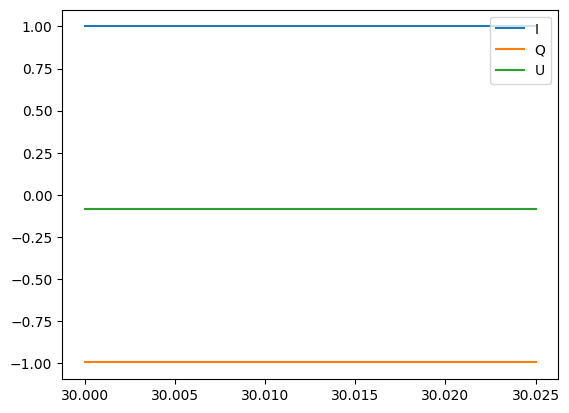

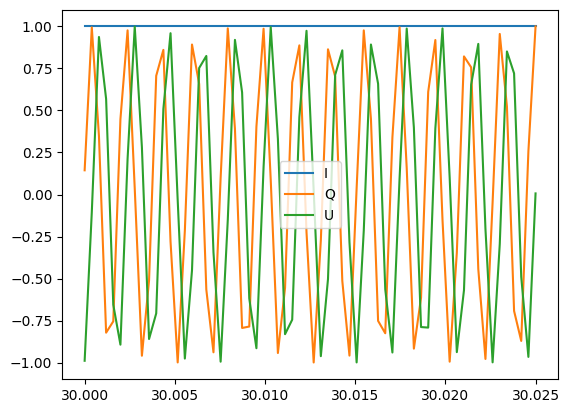

In [80]:
alpha0 = -RM * (c/23e9)**2  # ref freq where alpha is 0
def stokes_analytic(frequencies=frequencies, faraday=True, alpha0=alpha0):
    wave = c / (frequencies * 1e6)  # wavelength in m
    if faraday:
        arg = 2 * (RM * wave**2 + alpha0)
    else:
        arg = 2 * alpha0 * np.ones(frequencies.size)
    s = np.array([np.ones(frequencies.size), -np.cos(arg), np.sin(arg)])
    return s, arg

nu64 = np.linspace(0, 25/1e3, 64) + FREQ  # 25 kHz bw split in NCHANS
stokes = stokes_analytic(frequencies=nu64, faraday=False)[0]
stokes_rot, arg = stokes_analytic(frequencies=nu64, faraday=True)

plt.figure()
plt.plot(nu64, stokes[0], label="I")
plt.plot(nu64, stokes[1], label="Q")
plt.plot(nu64, stokes[2], label="U")
plt.legend()
plt.show()


plt.figure()
plt.plot(nu64, stokes_rot[0], label="I")
plt.plot(nu64, stokes_rot[1], label="Q")
plt.plot(nu64, stokes_rot[2], label="U")
plt.legend()
plt.show()

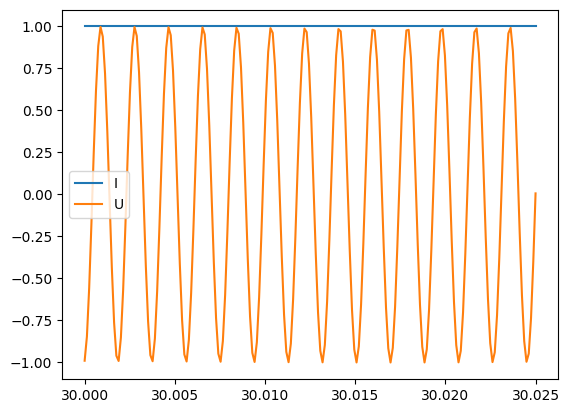

In [85]:
nu200 = np.linspace(0, 25/1e3, 200) + FREQ  # 250 kHz bw split in NCHANS
stokes_rot, arg2 = stokes_analytic(frequencies=nu200, faraday=True)

plt.figure()
plt.plot(nu200, stokes_rot[0], label="I")
#plt.plot(nu200, stokes_rot[1], label="Q")
plt.plot(nu200, stokes_rot[2], label="U")
plt.legend()
plt.show()

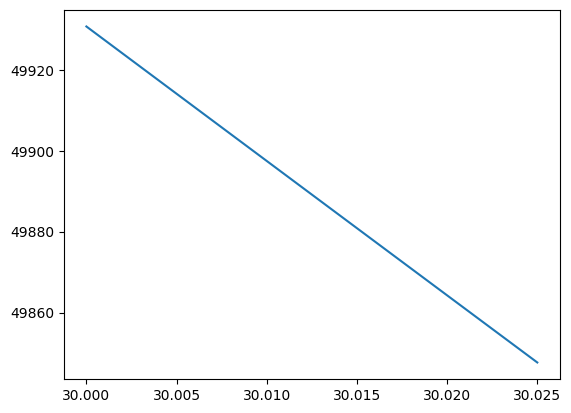

In [83]:
plt.figure()
plt.plot(nu64, arg)
plt.show()

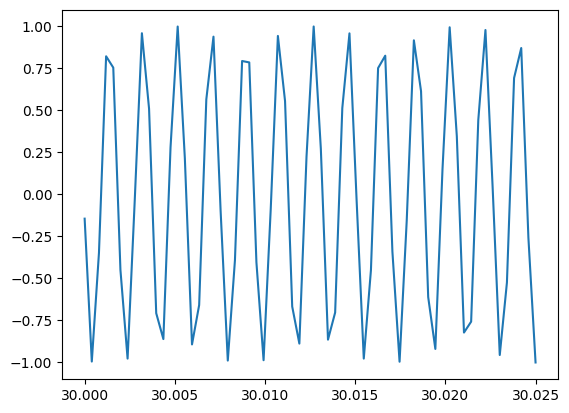

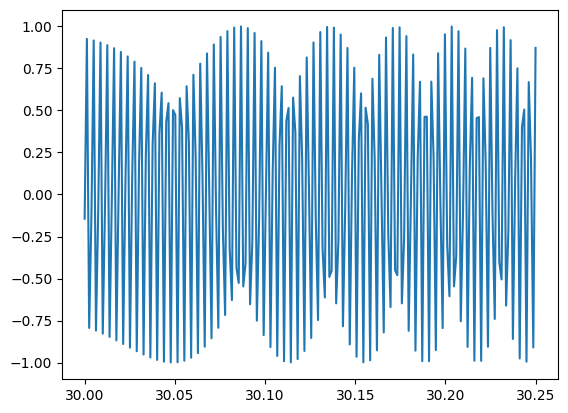

In [84]:
plt.figure()
plt.plot(nu64, np.cos(arg))
plt.show()

plt.figure()
plt.plot(nu200, np.cos(arg2))
plt.show()

## Short Dipole Beam

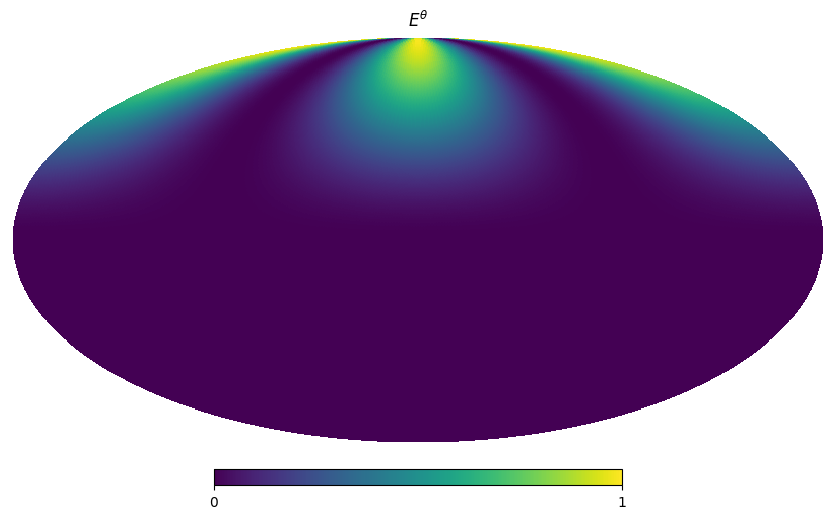

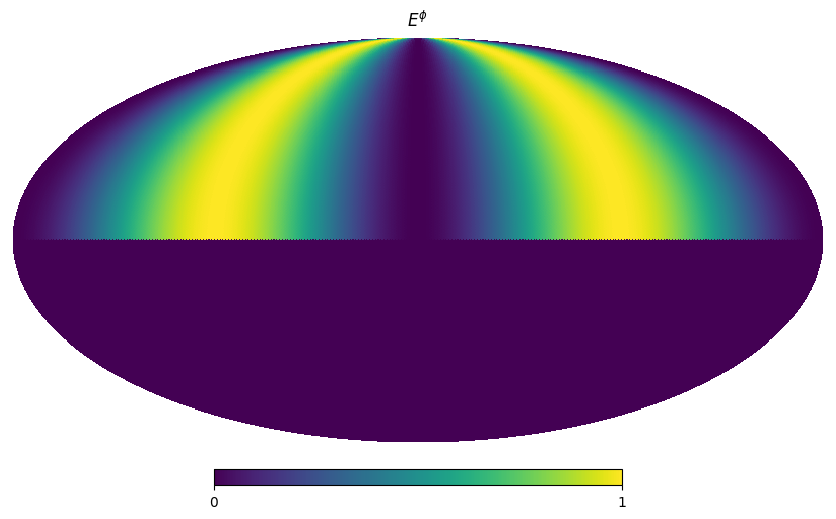

In [72]:
beam = fd.ShortDipole(NSIDE, frequency=FREQ)
hp.mollview(beam.beam_X[0]**2, title="$E^{\\theta}$", min=0, max=1)
plt.show()
hp.mollview(beam.beam_X[1]**2, title="$E^{\\phi}$", min=0, max=1)
plt.show()

# hp.mollview(beam.beam_Y[0]**2, title="$E^{\\theta}$", min=0, max=1)
# plt.show()
# hp.mollview(beam.beam_Y[1]**2, title="$E^{\\phi}$", min=0, max=1)
# plt.show()

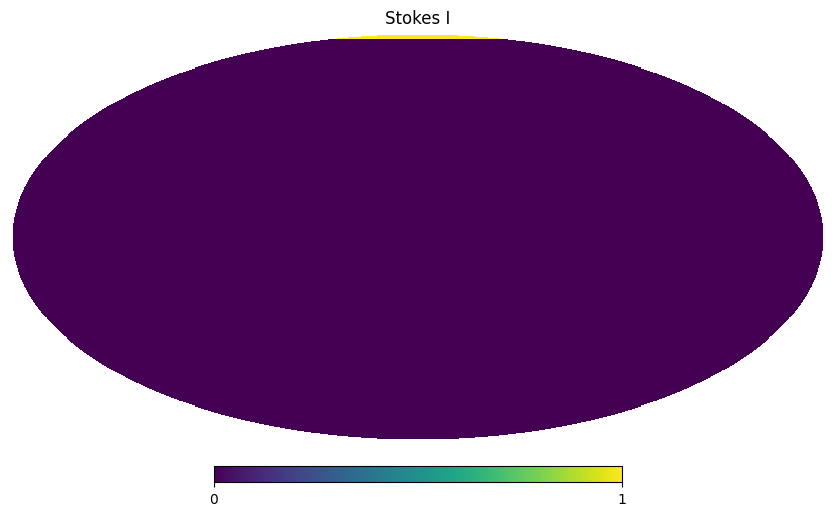

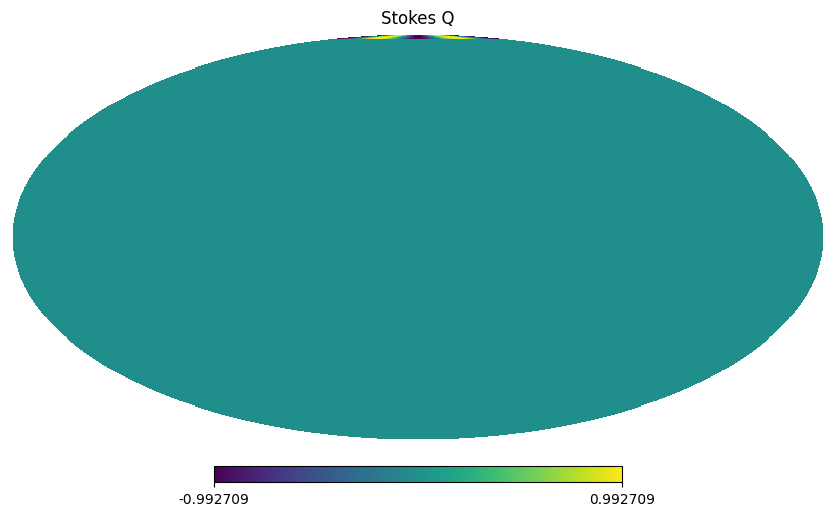

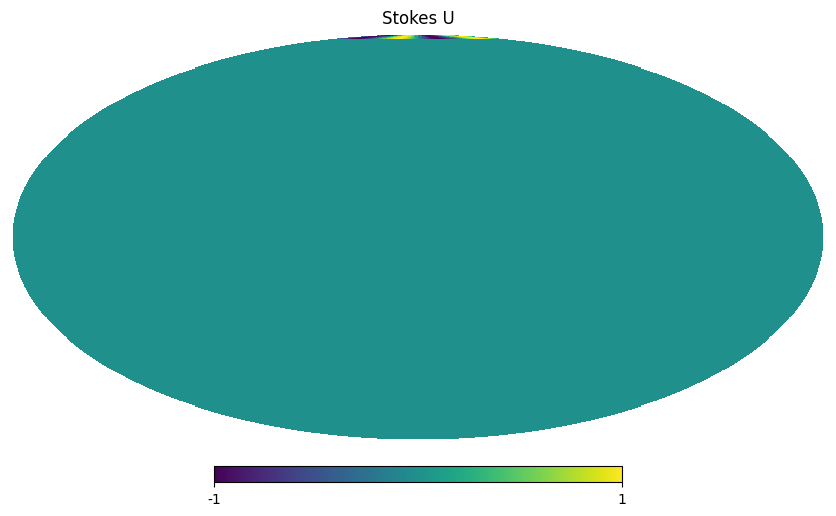

(1, 3, 196608)
(1, 3, 364)
(64, 3, 364)


In [73]:
sky = fd.Sky.zeros(NSIDE, freq=FREQ)
sky.add_point_source(extent=THETA_MAX)  # 5 deg source at zenith
hp.mollview(sky.stokes[0, 0], title="Stokes I")
plt.show()
hp.mollview(sky.stokes[0, 1], title="Stokes Q")
plt.show()
hp.mollview(sky.stokes[0, 2], title="Stokes U")
plt.show()

print(sky.stokes.shape)
pix = sky.del_dark_pixels()  # pixels to keep
beam.del_pix(pix)
print(sky.stokes[..., sky.bright_pixels].shape)
sky.power_law(frequencies, -2.5)
print(sky.stokes.shape)

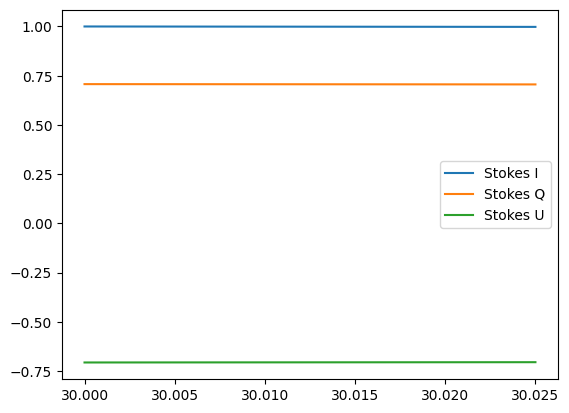

In [74]:
plt.figure()
plt.plot(frequencies, sky.stokes[:, 0, 10], label="Stokes I")
plt.plot(frequencies, sky.stokes[:, 1, 10], label="Stokes Q")
plt.plot(frequencies, sky.stokes[:, 2, 10], label="Stokes U")
plt.legend()
plt.show()

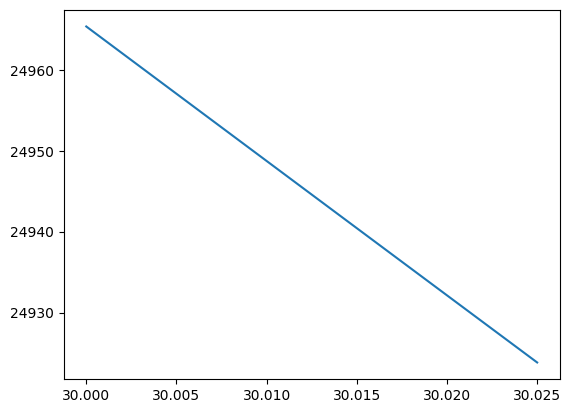

In [75]:
plt.figure
plt.plot(sky.freq, fd.sky.pol_angle(sky.freq, 250, 23e3))
plt.show()

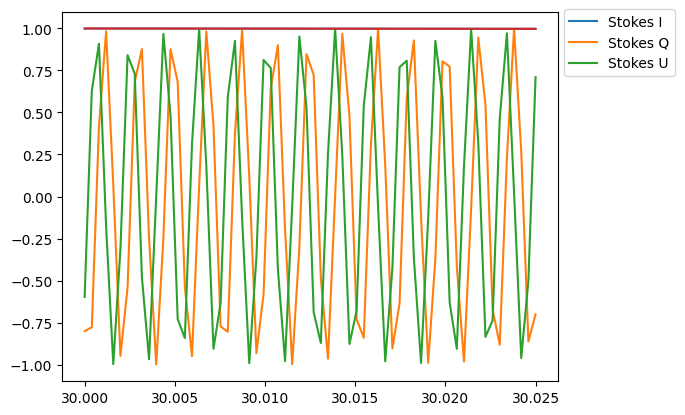

In [76]:
sky.apply_faraday(RM)

plt.figure()
plt.plot(sky.freq, sky.stokes_rot[:, 0, 10], label="Stokes I")
plt.plot(sky.freq, sky.stokes_rot[:, 1, 10], label="Stokes Q")
plt.plot(sky.freq, sky.stokes_rot[:, 2, 10], label="Stokes U")
plt.plot(sky.freq, np.sqrt(sky.stokes_rot[:, 1, 10]**2 + sky.stokes_rot[:, 2, 10]**2))
plt.legend(bbox_to_anchor=[1.25, 1.025])
plt.show()

In [77]:
sim = fd.Simulator(beam, sky)
sim.run()

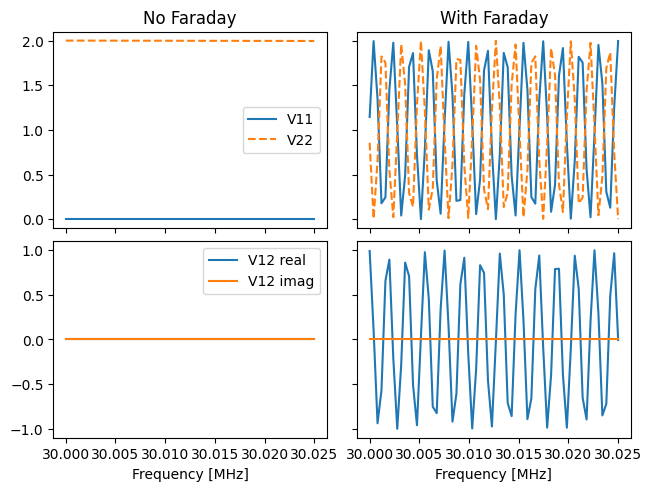

In [78]:
fd.sim.plot_vis(frequencies, sim.vis, sim.vis_rot)

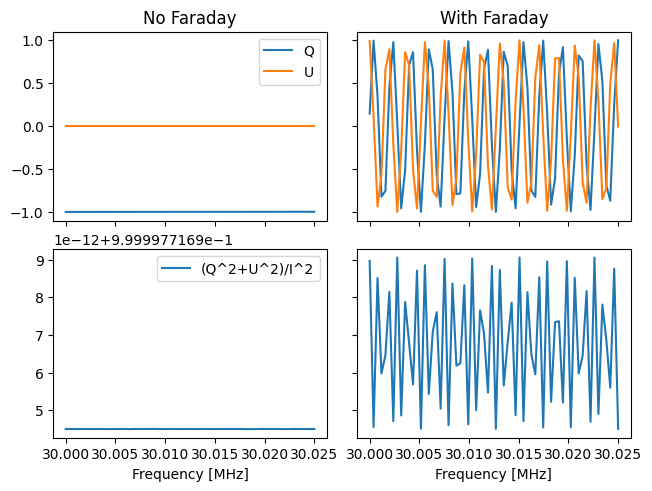

In [79]:
fd.sim.plot_stokes(frequencies, sim.stokes, sim.stokes_rot)